In [98]:
#imports
import numpy as np
import numpy.linalg as la
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.special import logsumexp

from treesampling.algorithms import kirchoff_rst
from treesampling.algorithms.castaway_legacy import castaway_rst, _castaway_rst_log
from treesampling.algorithms.castaway import CastawayRST
from treesampling.utils.visualization import plot_logweights_heatmap
from treesampling.utils.graphs import random_weakly_connected_k_subgraphs, tree_to_newick, graph_weight, block_matrix, \
    normalize_graph_weights
from treesampling.algorithms import kirchoff_rst, colbourn_rst

# Investigation on the weakly connected graph for no-trick
This notebook investigates on why Castaway fails where also Kirchoff fails. The purpose is to identify the error with the version without update trick that runs in $O(n^4)$ so to fix it and
beat the determinant based algorithms.

In [100]:
# build a graph that is easy to interpret
n = 8
root = 0
log_weight_matrix = block_matrix(n_nodes=n, n_blocks=2, root=root, low_weight=-500, log_probs=True)
weight_matrix = np.exp(log_weight_matrix)

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_57906/3944643029.py:4: RuntimeWarning: invalid value encountered in subtract
  sns.heatmap(log_weight_matrix - logsumexp(log_weight_matrix, axis=0, keepdims=True), annot=True, cmap='Blues', fmt='.2f', ax=axs[1])


Text(0.5, 1.0, 'Normalized Log Weight Matrix')

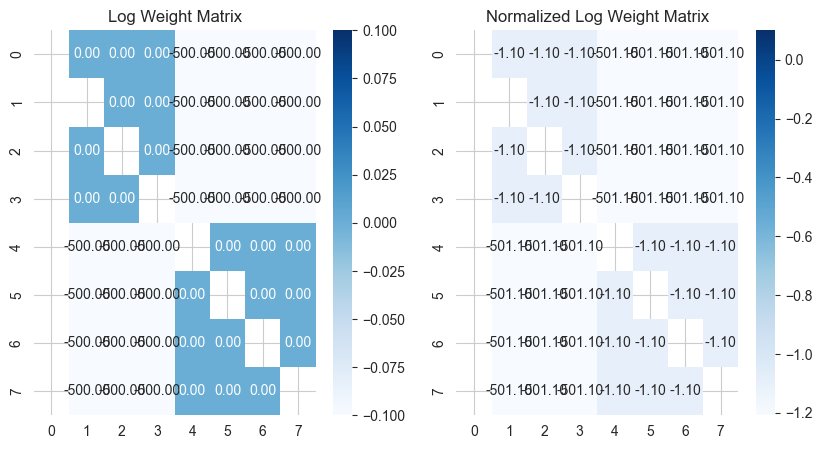

In [101]:
# empty tiles are -inf
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(log_weight_matrix, annot=True, cmap='Blues', fmt='.2f', ax=axs[0])
sns.heatmap(log_weight_matrix - logsumexp(log_weight_matrix, axis=0, keepdims=True), annot=True, cmap='Blues', fmt='.2f', ax=axs[1])
axs[0].set_title('Log Weight Matrix')
axs[1].set_title('Normalized Log Weight Matrix')

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_57906/931441090.py:3: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(np.log(weight_matrix), annot=weight_matrix, cmap='Blues', ax=ax[0])
/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_57906/931441090.py:4: RuntimeWarning: invalid value encountered in divide
  norm_weight_matrix = weight_matrix / weight_matrix.sum(axis=0, keepdims=True)
/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_57906/931441090.py:5: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(np.log(norm_weight_matrix), annot=norm_weight_matrix, cmap='Blues', ax=ax[1])


Text(0.5, 1.0, 'Normalized Weight Matrix')

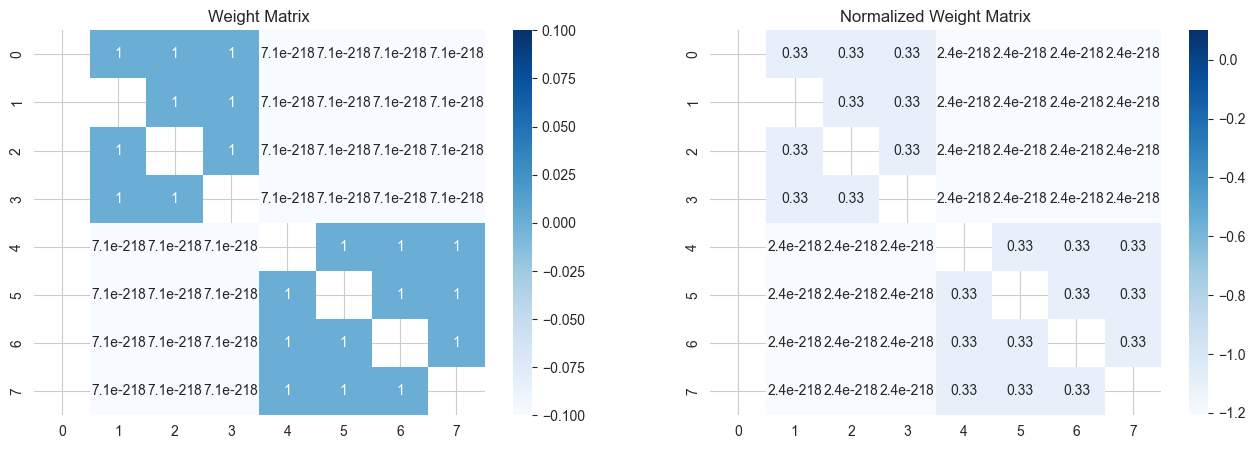

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
# plot weight matrix and normalized weight matrix (color based on log values to actually see if zero or not)
sns.heatmap(np.log(weight_matrix), annot=weight_matrix, cmap='Blues', ax=ax[0])
norm_weight_matrix = weight_matrix / weight_matrix.sum(axis=0, keepdims=True)
sns.heatmap(np.log(norm_weight_matrix), annot=norm_weight_matrix, cmap='Blues', ax=ax[1])
ax[0].set_title('Weight Matrix')
ax[1].set_title('Normalized Weight Matrix')


In [116]:
# laplacian and condition number
L = weight_matrix.sum(axis=0) - weight_matrix
L1r = L[1:, 1:]
la.cond(L1r)

18.440306508910552

In [118]:
# verify that kirchoff (and colbourn) fail
graph = nx.from_numpy_array(weight_matrix, create_using=nx.DiGraph())
graph.remove_edges_from([(u, v) for u, v in graph.edges() if u == v or v == root])
tree = kirchoff_rst(graph, root=root)
print(tree_to_newick(tree))

candidates:  [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2), (4, 5), (4, 6), (4, 7), (5, 4), (5, 6), (5, 7), (6, 4), (6, 5), (6, 7), (7, 4), (7, 5), (7, 6), (0, 4), (0, 5), (0, 6), (0, 7), (1, 4), (1, 5), (1, 6), (1, 7), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 1), (4, 2), (4, 3), (5, 1), (5, 2), (5, 3), (6, 1), (6, 2), (6, 3), (7, 1), (7, 2), (7, 3)]
current tree:  []
a: 9.097026338035105e-17, aa: 4.5485131690175654e-17
acceptance ratio: 0.5000000000000014
adding edge (0, 1)
candidates:  [(0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (3, 2), (4, 5), (4, 6), (4, 7), (5, 4), (5, 6), (5, 7), (6, 4), (6, 5), (6, 7), (7, 4), (7, 5), (7, 6), (0, 4), (0, 5), (0, 6), (0, 7), (1, 4), (1, 5), (1, 6), (1, 7), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 2), (4, 3), (5, 2), (5, 3), (6, 2), (6, 3), (7, 2), (7, 3)]
current tree:  [(0, 1)]
a: 4.5485131690175654e-17, aa: 1.7056924383815816e-17
acceptance ratio: 0.3749999999999988
ex

/Users/zemp/PycharmProjects/treesampling/src/treesampling/algorithms/__init__.py:69: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio = aa / a
/Users/zemp/PycharmProjects/treesampling/src/treesampling/algorithms/__init__.py:69: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_ratio = aa / a


In [119]:
graph = nx.from_numpy_array(weight_matrix, create_using=nx.DiGraph())
graph.remove_edges_from([(u, v) for u, v in graph.edges() if v == 0 or u == v])
tree = colbourn_rst(graph, root=root)
tree_to_newick(tree)


/Users/zemp/PycharmProjects/treesampling/src/treesampling/utils/math.py:50: RuntimeWarning: invalid value encountered in divide
  return arr / np.sum(arr, axis=axis, keepdims=True)
/Users/zemp/PycharmProjects/treesampling/src/treesampling/algorithms/__init__.py:169: RuntimeWarning: divide by zero encountered in divide
  # re-normalize
/Users/zemp/PycharmProjects/treesampling/src/treesampling/algorithms/__init__.py:169: RuntimeWarning: invalid value encountered in divide
  # re-normalize


ValueError: probabilities contain NaN

In [75]:
log_graph = nx.from_numpy_array(np.log(weight_matrix), create_using=nx.DiGraph)

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_57906/3474216704.py:1: RuntimeWarning: divide by zero encountered in log
  log_graph = nx.from_numpy_array(np.log(weight_matrix), create_using=nx.DiGraph)


In [120]:
np.log(weight_matrix)
log_graph = nx.from_numpy_array(np.log(weight_matrix), create_using=nx.DiGraph)

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_57906/2863255285.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(weight_matrix)
/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_57906/2863255285.py:2: RuntimeWarning: divide by zero encountered in log
  log_graph = nx.from_numpy_array(np.log(weight_matrix), create_using=nx.DiGraph)


In [121]:
np.log(0)

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_57906/1608527138.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(0)


-inf

In [122]:
nx.to_numpy_array(log_graph)

array([[ -inf,    0.,    0.,    0., -500., -500., -500., -500.],
       [ -inf,  -inf,    0.,    0., -500., -500., -500., -500.],
       [ -inf,    0.,  -inf,    0., -500., -500., -500., -500.],
       [ -inf,    0.,    0.,  -inf, -500., -500., -500., -500.],
       [ -inf, -500., -500., -500.,  -inf,    0.,    0.,    0.],
       [ -inf, -500., -500., -500.,    0.,  -inf,    0.,    0.],
       [ -inf, -500., -500., -500.,    0.,    0.,  -inf,    0.],
       [ -inf, -500., -500., -500.,    0.,    0.,    0.,  -inf]])

In [123]:
tree = _castaway_rst_log(log_weight_matrix, root=0, trick=False)
tree_to_newick(tree), graph_weight(tree, log_probs=True), [tree.edges()[e]['weight'] for e in tree.edges()]


('(((2)1,(5,(4)6)7)3)0',
 -509.70406052783926,
 [-1.3862943611198906,
  -1.3862943611198906,
  -1.3862943611198906,
  -501.3862943611199,
  -1.3862943611198906,
  -1.3862943611198906,
  -1.3862943611198906])

In [124]:
norm_graph = normalize_graph_weights(graph)
mst = nx.maximum_spanning_arborescence(norm_graph)
tree_to_newick(mst), np.log(graph_weight(mst))

/Users/zemp/PycharmProjects/treesampling/src/treesampling/utils/math.py:50: RuntimeWarning: invalid value encountered in divide
  return arr / np.sum(arr, axis=axis, keepdims=True)
/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_57906/1700088202.py:3: RuntimeWarning: invalid value encountered in log
  tree_to_newick(mst), np.log(graph_weight(mst))


('(1,2,3,(5,(7)6)4)0', nan)

<Axes: >

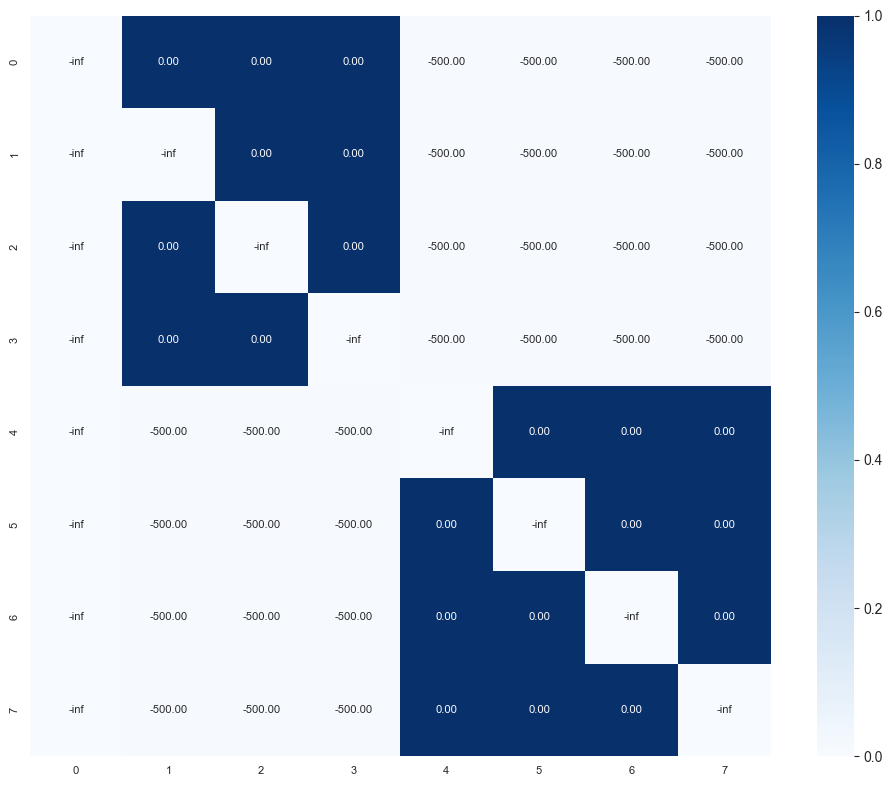

In [125]:
plot_logweights_heatmap(nx.to_numpy_array(log_graph))

In [126]:
# new implementation
smplr = CastawayRST(log_graph, root=0, trick=False, log_probs=True)

edge 3 -> 2 has weight 1.0, all other edges in node 2 will be set to 0.
edge 7 -> 6 has weight 1.0, all other edges in node 6 will be set to 0.
/Users/zemp/PycharmProjects/treesampling/src/treesampling/utils/math.py:48: RuntimeWarning: invalid value encountered in subtract
  return arr - sp.logsumexp(arr, axis=axis, keepdims=True)


# Random weights
we add randomness to the block matrix to have variability in the weights

/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_57906/598401500.py:3: RuntimeWarning: invalid value encountered in divide
  norm_rweigh_matrix = rweigh_matrix / rweigh_matrix.sum(axis=0, keepdims=True)
/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_57906/598401500.py:6: RuntimeWarning: divide by zero encountered in log
  rlog_weight_matrix = np.log(rweigh_matrix)
/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_57906/598401500.py:7: RuntimeWarning: invalid value encountered in subtract
  norm_rlog_weight_matrix = rlog_weight_matrix - logsumexp(rlog_weight_matrix, axis=0, keepdims=True)


Text(0.5, 1.0, 'Normalized log weight matrix')

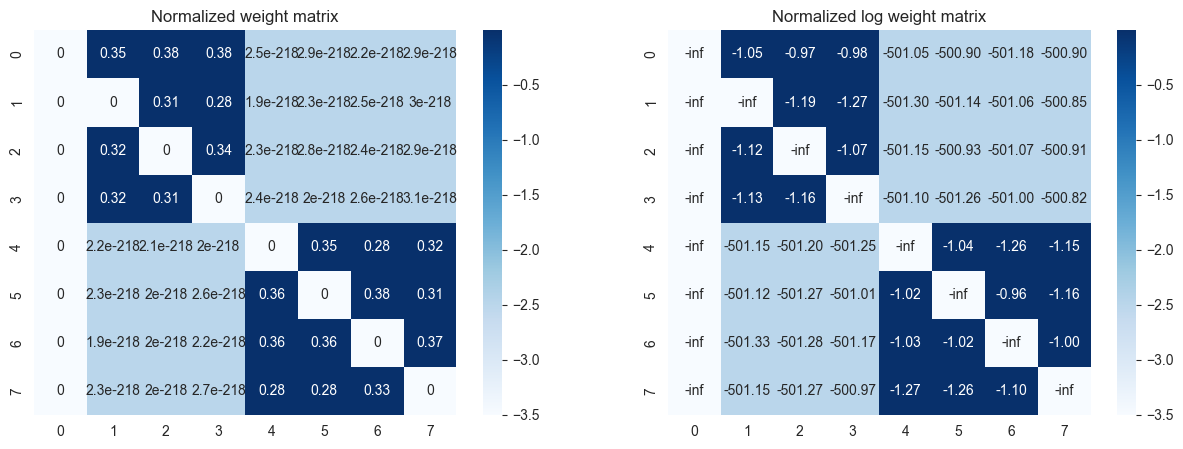

In [144]:
# build both exp and log form (and normalized)
rweigh_matrix = weight_matrix * np.random.uniform(0.8, 1.2, size=weight_matrix.shape)
norm_rweigh_matrix = rweigh_matrix / rweigh_matrix.sum(axis=0, keepdims=True)
norm_rweigh_matrix[:, 0] = 0

rlog_weight_matrix = np.log(rweigh_matrix)
norm_rlog_weight_matrix = rlog_weight_matrix - logsumexp(rlog_weight_matrix, axis=0, keepdims=True)
norm_rlog_weight_matrix[:, 0] = -np.inf

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# to color the cells based on the log values and see the differences
col_mat = norm_rlog_weight_matrix.copy() / 200
col_mat[np.isneginf(norm_rlog_weight_matrix)] = np.min(col_mat[~np.isneginf(col_mat)]) - 1
sns.heatmap(col_mat, annot=norm_rweigh_matrix, cmap='Blues', ax=axs[0])
sns.heatmap(col_mat, annot=norm_rlog_weight_matrix, cmap='Blues', fmt='.2f', ax=axs[1])
axs[0].set_title('Normalized weight matrix')
axs[1].set_title('Normalized log weight matrix')

In [145]:
L = rweigh_matrix.sum(axis=0) - rweigh_matrix
L1r = L[1:, 1:]
la.cond(L1r)

24.234376433376877

In [146]:
tree = kirchoff_rst(nx.from_numpy_array(norm_rweigh_matrix, create_using=nx.DiGraph()), root=0)
tree_to_newick(tree), np.log(graph_weight(norm_rweigh_matrix))

candidates:  [(5, 6), (0, 2), (0, 3), (6, 7), (6, 5), (5, 4), (6, 4), (4, 5), (0, 1), (2, 3), (7, 6), (2, 1), (3, 1), (4, 7), (3, 2), (5, 7), (1, 2), (7, 5), (4, 6), (1, 3), (7, 4), (3, 7), (1, 7), (0, 7), (0, 5), (2, 7), (2, 5), (7, 3), (3, 6), (5, 3), (0, 4), (1, 6), (2, 6), (3, 4), (5, 1), (1, 5), (2, 4), (7, 1), (4, 1), (6, 3), (0, 6), (4, 2), (4, 3), (3, 5), (5, 2), (7, 2), (6, 2), (1, 4), (6, 1)]
current tree:  []
a: -7.753118107031921e-17, aa: -2.5492695837219546e-17
acceptance ratio: 0.3288057202959179
adding edge (5, 6)
candidates:  [(0, 2), (0, 3), (6, 7), (5, 4), (6, 4), (4, 5), (0, 1), (2, 3), (2, 1), (3, 1), (4, 7), (3, 2), (5, 7), (1, 2), (7, 5), (1, 3), (7, 4), (3, 7), (1, 7), (0, 7), (0, 5), (2, 7), (2, 5), (7, 3), (5, 3), (0, 4), (3, 4), (5, 1), (1, 5), (2, 4), (7, 1), (4, 1), (6, 3), (4, 2), (4, 3), (3, 5), (5, 2), (7, 2), (6, 2), (1, 4), (6, 1)]
current tree:  [(5, 6)]
a: -2.5492695837219546e-17, aa: -1.376674755373943e-17
acceptance ratio: 0.5400271372492456
excludi

/Users/zemp/PycharmProjects/treesampling/src/treesampling/algorithms/__init__.py:69: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio = aa / a


IndexError: pop from empty list

In [147]:
# colbourn
tree = colbourn_rst(nx.from_numpy_array(norm_rweigh_matrix, create_using=nx.DiGraph()), root=0)

/Users/zemp/PycharmProjects/treesampling/src/treesampling/utils/math.py:50: RuntimeWarning: invalid value encountered in divide
  return arr / np.sum(arr, axis=axis, keepdims=True)
/Users/zemp/PycharmProjects/treesampling/src/treesampling/algorithms/__init__.py:169: RuntimeWarning: divide by zero encountered in divide
  # re-normalize
/Users/zemp/PycharmProjects/treesampling/src/treesampling/algorithms/__init__.py:169: RuntimeWarning: invalid value encountered in divide
  # re-normalize


ValueError: probabilities contain NaN

In [150]:
# castaway
tree = _castaway_rst_log(norm_rweigh_matrix, root=0, trick=False)
tree_to_newick(tree), graph_weight(tree, log_probs=True)

('((((4,7)1)3,6)2,5)0', -14.48069223217614)